In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pprint import pprint
import astropy.units as u
from astropy.units import Quantity
from astropy.table import Table, vstack
from gammapy.spectrum import FluxPoints
from numpy import isnan

# Temporarily fixing environment variable for gamma-cat
import os
os.environ['GAMMA_CAT'] = os.path.join('C:/Users/Arjun/github/gamma-cat')

## The source

HESS J1809-193

3FGL J1810.1-1910

In [30]:
# Preparing Fermi data
from gammapy.catalog import SourceCatalog3FGL

cat_f = SourceCatalog3FGL()
source_f = cat_f['3FGL J1810.1-1910']

data_f = source_f.flux_points.table

data_f['e_ref'] = data_f['e_ref'].to('TeV')
data_f['e_min'] = data_f['e_min'].to('TeV')
data_f['e_max'] = data_f['e_max'].to('TeV')

dnde_err_f = data_f['dnde'] * (data_f['flux_errn'] / data_f['flux'])
data_f['dnde_err'] = dnde_err_f.to(data_f['dnde'].unit)

data_f

e_ref,e_min,e_max,flux,flux_errn,flux_errp,eflux,eflux_errn,eflux_errp,is_ul,flux_ul,eflux_ul,dnde,dnde_err
TeV,TeV,TeV,1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),,1 / (cm2 s),erg / (cm2 s),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float32,float32,float32,float32,float32,float32,bool,float64,float64,float64,float64
0.000173205080757,0.0001,0.0003,nan,nan,nan,nan,nan,nan,True,2.46259137526e-08,5.86174208131e-12,1.094433751e-06,nan
0.000547722557505,0.0003,0.001,1.98833e-08,3.66118e-09,3.68171e-09,1.34973e-11,2.48531e-12,2.49925e-12,False,nan,nan,2.80812731711e-05,5.17070478331e-06
0.00173205080757,0.001,0.003,1.68924e-09,6.92199e-10,7.14229e-10,4.02091e-12,1.64765e-12,1.70009e-12,False,nan,nan,8.3655209982e-07,3.42794562249e-07
0.00547722557505,0.003,0.01,5.52505e-10,1.53378e-10,1.64626e-10,3.75056e-12,1.04117e-12,1.11753e-12,False,nan,nan,7.80305576995e-08,2.16616401915e-08
0.0316227766017,0.01,0.1,1.20605e-10,4.70561e-11,5.49654e-11,2.06504e-12,8.05712e-13,9.41138e-13,False,nan,nan,1.28889717386e-09,5.02885717121e-10


In [32]:
# Preparing gamma-cat data
from gammapy.catalog import SourceCatalogGammaCat

cat_g = SourceCatalogGammaCat()
source_g = cat_g['HESS J1809-193']

data_g = source_g.flux_points.table
dnde_err_g = data_g['dnde'] * (data_g['dnde_errn'] / data_g['dnde'])
data_g['dnde_err'] = dnde_err_g.to(data_g['dnde'].unit)

data_g

e_ref,dnde,dnde_errp,dnde_errn,dnde_ul,dnde_err
TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float32,float32,float32,float32,float32,float32
0.354987,8.48195e-11,2.63877e-11,2.65445e-11,nan,2.65445e-11
0.73622,1.01737e-11,2.89366e-12,2.91417e-12,nan,2.91417e-12
1.56401,3.54103e-12,5.62967e-13,5.69983e-13,nan,5.69983e-13
3.34311,5.06506e-13,1.39524e-13,1.41949e-13,nan,1.41949e-13
7.15709,1.25451e-13,3.53979e-14,3.64408e-14,nan,3.64408e-14
15.2979,7.85999e-15,7.38577e-15,7.81593e-15,nan,7.81593e-15
32.9055,2.70465e-15,1.44023e-15,1.72634e-15,nan,1.72634e-15


In [33]:
# Combining data
colnames=['e_ref', 'dnde', 'dnde_err']

data_combined = vstack([
                    data_f[colnames], 
                    data_g[colnames]
                    ])

flux_points = FluxPoints(data_combined)

flux_points.table

mask = ~np.isnan(flux_points.table['dnde_err'])
flux_points.table = flux_points.table[mask]

flux_points.table

e_ref,dnde,dnde_err
TeV,1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64
0.000547722557505,2.80812731711e-05,5.17070478331e-06
0.00173205080757,8.3655209982e-07,3.42794562249e-07
0.00547722557505,7.80305576995e-08,2.16616401915e-08
0.0316227766017,1.28889717386e-09,5.02885717121e-10
0.354986995459,8.48194986469e-11,2.65444992376e-11
0.736220002174,1.01737004238e-11,2.91416999039e-12
1.56401002407,3.54103009935e-12,5.69983025622e-13
3.34311008453,5.06506024189e-13,1.4194899325e-13


## Plot data and model

<Container object of 3 artists>

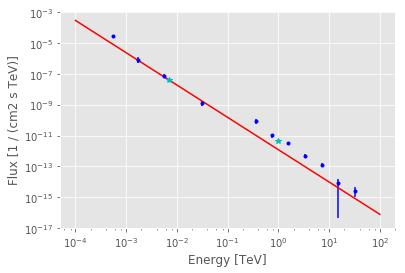

In [34]:
# Defining units
energy_range = [1e-4, 100] * u.TeV
opts = dict(energy_unit='TeV', flux_unit='cm-2 s-1 TeV-1', energy_range=energy_range)

source_f.spectral_model.plot(**opts, color='r')
# Using the combined energy range to stretch to gamma-cat data

p_f = source_f.spectral_model.parameters
p_g = source_g.spectral_model.parameters
plt.plot(p_f['reference'].value / 1e6, p_f['amplitude'].value * 1e6, '*', color='c')
plt.plot(p_g['reference'].value, p_g['amplitude'].value, '*', color='c')



# Combined 3FGL + gamma-cat:
# TODO: Split the colors for the flux points (first 5 purple, last 6 red)
# Instead of the below code, I can call plt.errorbar() for each catalog individually. 

plt.errorbar(x=flux_points.table['e_ref'],
             y=flux_points.table['dnde'],
             yerr=flux_points.table['dnde_err'],
             fmt='.',
             color='b'
            )

## Defining chi2 function

First let's use PowerLaw.

In [35]:
from gammapy.spectrum.models import PowerLaw

class MyChi2:

    def __init__(self, flux_points, spectral_model):
        self.flux_points = flux_points
        self.spectral_model = spectral_model
    
    def __call__(self, amplitude, index):

        t = self.flux_points.table
        
        dnde_model = PowerLaw.evaluate( # Should be calling: spectral_model.evaluate()
            energy=t['e_ref'],
            amplitude=amplitude,
            index=index,
            reference=1 # 1 TeV
        )

        chi = (t['dnde'] - dnde_model) / t['dnde_err']
        return np.sum(chi ** 2)

## Defining Chi2Fitter class and running a fit

In [36]:
from iminuit import Minuit

class Chi2Fitter(object):
    def __init__(self, flux_points, spectral_model):
        self.flux_points = flux_points
        self.spectral_model = spectral_model
        self.minuit = None
    
    def fit(self):

        chi2 = MyChi2(self.flux_points, self.spectral_model)
        
        pars = dict(
            amplitude=self.spectral_model.parameters['amplitude'].value,
            index = self.spectral_model.parameters['index'].value
        )
        
        minuit = Minuit(chi2, **pars)
        
        minuit.migrad()
        minuit.hesse()
        
        self.minuit = minuit

In [40]:
spectral_model = PowerLaw(
    reference=1,
    amplitude=1e-12, # p_g['amplitude'].value 
    index=1.0 # p_g['index'].value
)

fitter = Chi2Fitter(flux_points=flux_points, spectral_model=spectral_model)
fitter.fit()

print(fitter.minuit.values)
print('\n', fitter.minuit.errors)


        
fitter.flux_points.table.pprint()

C:\Users\Arjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: InitialParamWarning: errordef is not given. Default to 1.
C:\Users\Arjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: InitialParamWarning: Parameter amplitude is floating but does not have initial step size. Assume 1.
C:\Users\Arjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: InitialParamWarning: Parameter index is floating but does not have initial step size. Assume 1.


FCN = 49.898858161170786 
 TOTAL NCALL = 130 
 NCALLS = 130 
 
 
 EDM = 7.4997773237425e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,amplitude,3.83981e-12,4.45514e-13,0,0,,,
2,index,1.90934,0.0333517,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,amplitude,3.83981e-12,4.45513e-13,0,0,,,
2,index,1.90934,0.0333516,0,0,,,


+,amplitude,index
amplitude,1.00,-0.46
index,-0.46,1.00


{'amplitude': 3.839808115341194e-12, 'index': 1.9093447029563522}

 {'amplitude': 4.4551331801120047e-13, 'index': 0.033351637481937306}
      e_ref              dnde            dnde_err    
       TeV         1 / (cm2 s TeV)   1 / (cm2 s TeV) 
----------------- ----------------- -----------------
0.000547722557505 2.80812731711e-05 5.17070478331e-06
 0.00173205080757  8.3655209982e-07 3.42794562249e-07
 0.00547722557505 7.80305576995e-08 2.16616401915e-08
  0.0316227766017 1.28889717386e-09 5.02885717121e-10
   0.354986995459 8.48194986469e-11 2.65444992376e-11
   0.736220002174 1.01737004238e-11 2.91416999039e-12
    1.56401002407 3.54103009935e-12 5.69983025622e-13
    3.34311008453 5.06506024189e-13  1.4194899325e-13
    7.15709018707 1.25451000499e-13  3.6440800735e-14
    15.2979001999   7.859989718e-15 7.81592960519e-15
    32.9054985046 2.70465010421e-15 1.72633996738e-15


## Final plot

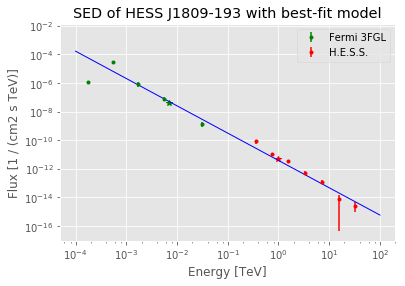

In [44]:
source_g.spectral_model.plot(linestyle='dashed', alpha=0, **opts)
# source_f.spectral_model.plot(linestyle='dashed', alpha=0.7, **opts)

plt.plot(p_f['reference'].value / 1e6, p_f['amplitude'].value * 1e6, '*', color='g')
plt.plot(p_g['reference'].value, p_g['amplitude'].value, '*', color='r')

fermi = plt.errorbar(x=data_f['e_ref'],
             y = data_f['dnde'],
             yerr = data_f['dnde_err'],
             fmt='.',
             color='g'
            )

hess = plt.errorbar(x=data_g['e_ref'],
             y = data_g['dnde'],
             yerr = data_g['dnde_err'],
             fmt='.',
             color='r'
            )


from gammapy.utils.energy import Energy
energy = Energy.equal_log_spacing(
    emin=energy_range[0],
    emax=energy_range[1],
    nbins=100,
)

spectral_model = PowerLaw(
    index=fitter.minuit.values['index'],
    amplitude=fitter.minuit.values['amplitude'],
    reference=1
    )

flux = spectral_model(
    energy=energy.to('TeV').value
#     amplitude = fitter.minuit.values['amplitude'],
#     index = fitter.minuit.values['index'],
#     reference=1,
)
plt.plot(energy, flux, linewidth=1, color='blue')

plt.legend([fermi, hess], ['Fermi 3FGL', 'H.E.S.S.'])

plt.title('SED of HESS J1809-193 with best-fit model')

## Reduced Minimum

In [45]:
print('\nMinimum value of function: ', fitter.minuit.fval)

result = fitter.minuit.fval / (len(flux_points.table) - len(fitter.minuit.args))
print('\nReduced minimum: ', result)


Minimum value of function:  49.898858161170786

Reduced minimum:  5.54431757346342
